# Linear Models

*Summary: I decided to forego using a linear model in my final ensemble due to concerns about linear regression assumptions being violated.  In particular, residuals deviate slightly from the normal distribution and there are serious multi-collinearity concerns even with a regularized model.*

In [1]:
KAGGLE=False # set to True if using the Kaggle version of the dataset

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
#import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso

from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [5]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

The data has been pre-processed and stored to a dataframe

In [6]:
def load_data(tree=None):
    if KAGGLE:
        train = pd.read_csv('data/train.csv')
        test = pd.read_csv('data/test.csv')
        num_train=np.shape(train)[0]
        num_test=np.shape(test)[0]
        alldata=train.append(test, ignore_index=True)
    else:
        alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

        #alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)
    return alldata

alldata=load_data()

- Choosing the best columns kept by lasso and RFs

In [7]:
# cols_selected=['KitchenQual',
#  'GarageYrBlt',
#  'BsmtHalfBath',
#  'MissingLoc',
#  'GrLivArea',
#  'ExterQual',
#  'PoolQC',
#  'HalfBath',
#  'GarageCars',
#  'LotArea',
#  'PavedDrive',
#  'WoodDeckSF',
#  'BsmtFinSF1',
#  'BsmtFullBath',
#  'GarageFinish',
#  'Heating',
#  'TotalBsmtSF',
#  'FireplaceQu',
#  'distToUI',
#  'Foundation',
#  'BsmtQual',
#  'KitchenAbvGr',
#  'MasVnrArea',
#  'Condition2',
#  'CentralAir',
#  'BsmtExposure',
#  'RoofStyle',
#  'BldgType',
#  'TotRmsAbvGrd',
#  'BsmtFinType1',
#  'MSZoning',
#  'GarageArea',
#  'SaleCondition',
#  'lats',
#  'GarageCond',
#  'LandSlope',
#  'Street',
#  'longs',
#  'Fireplaces',
#  'BedroomAbvGr',
#  'FullBath',
#  'BsmtUnfSF',
#  'YearBuilt',
#  'OverallQual',
#  'OpenPorchSF',
#  'HouseStyle',
#  'RoofMatl',
#  'GarageType',
#  'YearRemodAdd',
#  'LotFrontage',
#  '1stFlrSF',
#  'OverallCond']

In [8]:
nums = [col for col in alldata.columns if alldata.dtypes[col] != 'object']
cats = [col for col in alldata.columns if alldata.dtypes[col] == 'object']
alldata=pd.get_dummies(alldata).reset_index(drop=True)

In [9]:
alldata['LogPrice']=np.log1p(alldata.SalePrice)

In [10]:
deps=list(set(alldata.columns)-set(['LogPrice','2ndFlrSF','SalePrice']))

In [11]:
def train_test_split_custom(data=alldata,y_var='SalePrice',cols=[]):
    y=data[y_var]
    X=data.drop([y_var],axis=1)
    X= X if not cols else X[cols]
    return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=deps)  

In [12]:
y=alldata['LogPrice'].values
X=alldata[deps].values
names = alldata[deps].columns

In [13]:
steps = [('scaling',StandardScaler()),
('lasso',Lasso(alpha=.01))]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=deps)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#pr

r2 score on train: 0.8967922971645896
r2 score on test: 0.9144162415780916


In [23]:
plt.rcParams["figure.figsize"] = (20, 10)
lasso_coef=pipeline['lasso'].coef_
names = X_train.columns
lasso_zips=zip(names,lasso_coef)
lasso_coef_clean = [tup for tup in lasso_zips if np.abs(tup[1])>.005]
names_clean = [tup[0] for tup in lasso_coef_clean]
coefs_clean = [tup[1] for tup in lasso_coef_clean]

In [24]:
lasso_coef_clean

[('YearBuilt', 0.04465454094511629),
 ('MSZoning_RM', -0.022479891290034273),
 ('BsmtExposure_Gd', 0.006219751458692483),
 ('PavedDrive_N', -0.006166921668502728),
 ('OverallCond', 0.03745795281059111),
 ('TotalBsmtSF', 0.037519579179752474),
 ('YearRemodAdd', 0.018532861067166017),
 ('OverallQual', 0.10355273395956896),
 ('BsmtQual_Ex', 0.00764315285459991),
 ('SaleCondition_Abnorml', -0.006450452690348058),
 ('GarageCars', 0.01859199082744266),
 ('BldgType_Twnhs', -0.005548932373971453),
 ('CentralAir_N', -0.01094888551322247),
 ('Condition1_Norm', 0.00733296153735067),
 ('KitchenQual_Ex', 0.008440156569674302),
 ('HeatingQC_Ex', 0.007668633606461766),
 ('Foundation_PConc', 0.011117563931642373),
 ('GarageArea', 0.016255909890685365),
 ('LotArea', 0.01418282866628437),
 ('MSZoning_C (all)', -0.00610791365952997),
 ('Condition2_PosN', -0.008527196792286092),
 ('Neighborhood_Crawfor', 0.011540304713245396),
 ('BsmtFinSF1', 0.02935897738394854),
 ('Fireplaces', 0.017650440471220896),
 (

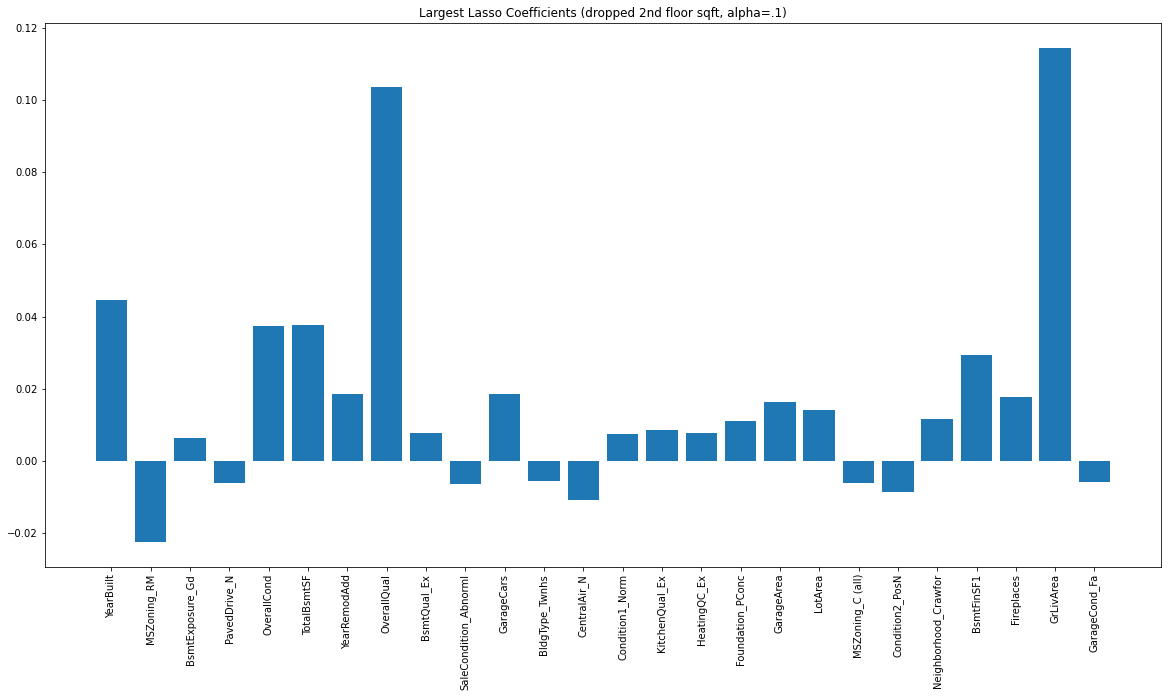

In [26]:

plt.bar(names_clean, coefs_clean)
plt.title('Largest Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [14]:
#AAAA
from sklearn.linear_model import Lasso
from  sklearn.feature_selection import RFE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=150,step=10,verbose=1)
rfe.fit(X_train,y_train)
cols_selected_lasso=list(alldata[deps].columns[rfe.support_])

Fitting estimator with 296 features.
Fitting estimator with 286 features.
Fitting estimator with 276 features.
Fitting estimator with 266 features.
Fitting estimator with 256 features.
Fitting estimator with 246 features.
Fitting estimator with 236 features.
Fitting estimator with 226 features.
Fitting estimator with 216 features.
Fitting estimator with 206 features.
Fitting estimator with 196 features.
Fitting estimator with 186 features.
Fitting estimator with 176 features.
Fitting estimator with 166 features.
Fitting estimator with 156 features.


In [15]:
cols_selected_lasso=list(X_train.columns[rfe.support_])

In [16]:
steps = [('scaling',StandardScaler()),
('lasso',Lasso(alpha=.01))]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=cols_selected_lasso)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#pr

r2 score on train: 0.8854966121449981
r2 score on test: 0.9037520017609523


In [ ]:
steps = [('scaling',StandardScaler()),
('lasso',Lasso(alpha=.01))]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=cols_selected_lasso)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#pr

r2 score on train: 0.8854966121449981
r2 score on test: 0.9037520017609523


In [18]:
len(cols_selected_lasso)

150

<AxesSubplot:>

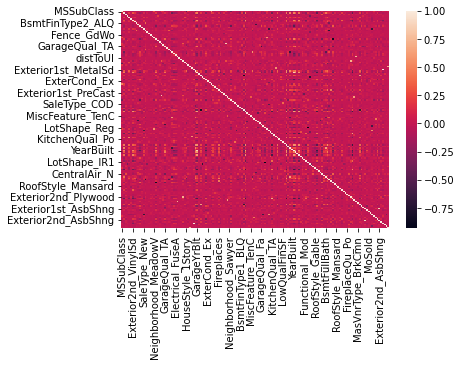

In [17]:
sns.heatmap(alldata[cols_selected_lasso].corr())

In [28]:
steps = [('scaling',StandardScaler()),
('linear',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=names_clean)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.9108248021226886
r2 score on test: 0.9101321023963198


In [35]:
plt.rcParams["figure.figsize"] = (20, 10)
lin_coef=pipeline['linear'].coef_
names = X_train.columns
lin_zips=zip(names,lin_coef)
lin_coef_clean = [tup for tup in lin_zips if np.abs(tup[1])>.005]
names_clean_lin = [tup[0] for tup in lin_coef_clean]
coefs_clean_lin = [tup[1] for tup in lin_coef_clean]

plt.bar(names_clean_lin, coefs_clean_lin)
plt.title('Largest Linear Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [30]:
pipeline['linear'].coef_

array([ 0.05709717, -0.02780323,  0.01423814, -0.00809332,  0.05648779,
        0.04074494,  0.01632079,  0.09433835,  0.01225765, -0.01499297,
        0.01844301, -0.0167052 , -0.01409545,  0.01598212,  0.0166889 ,
        0.01458688,  0.02185692,  0.01757001,  0.02147325, -0.01282399,
       -0.02178859,  0.01957408,  0.03529917,  0.02154402,  0.11961607,
       -0.01216249])

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def print_vifs(data=alldata,coef_names=names_clean_lin):


    vif_data = pd.DataFrame()
    vif_data["feature"] = coef_names

    vif_data["VIF"] = [variance_inflation_factor(data[coef_names].values, i)
                              for i in range(len(data[coef_names].columns))]

    print(vif_data)

In [40]:
print_vifs()

                  feature           VIF
0               YearBuilt  13504.468832
1             MSZoning_RM      1.609850
2         BsmtExposure_Gd      1.398510
3            PavedDrive_N      1.561133
4             OverallCond     44.685390
5             TotalBsmtSF     14.282678
6            YearRemodAdd  14350.934198
7             OverallQual     59.457847
8             BsmtQual_Ex      1.798143
9   SaleCondition_Abnorml      1.047191
10             GarageCars     36.860068
11         BldgType_Twnhs      1.180906
12           CentralAir_N      1.438331
13        Condition1_Norm      7.788720
14         KitchenQual_Ex      1.596093
15           HeatingQC_Ex      3.014850
16       Foundation_PConc      3.382573
17             GarageArea     31.873168
18                LotArea      3.163758
19       MSZoning_C (all)      1.083290
20        Condition2_PosN      1.049728
21   Neighborhood_Crawfor      1.134822
22             BsmtFinSF1      3.266699
23             Fireplaces      2.776934


In [41]:
steps = [('scaling',StandardScaler()),
('linear',LinearRegression())]
pipeline = Pipeline(steps)
names_clean_no_remod = list(set(names_clean) - set(['YearRemodAdd']))
X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=names_clean_no_remod)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.9098403694840165
r2 score on test: 0.910237396127752


In [42]:
print_vifs(data=alldata,coef_names=names_clean_no_remod)

                  feature        VIF
0            HeatingQC_Ex   2.998904
1            PavedDrive_N   1.458652
2              Fireplaces   2.776309
3                 LotArea   3.159492
4              GarageCars  36.686373
5         Condition2_PosN   1.049659
6          BldgType_Twnhs   1.167570
7             MSZoning_RM   1.513829
8        Foundation_PConc   3.369402
9               YearBuilt  78.436737
10           CentralAir_N   1.408317
11              GrLivArea  19.243561
12        Condition1_Norm   7.788559
13          GarageCond_Fa   1.153139
14   Neighborhood_Crawfor   1.123859
15            OverallCond  31.666952
16             BsmtFinSF1   3.239475
17            BsmtQual_Ex   1.798101
18  SaleCondition_Abnorml   1.047162
19        BsmtExposure_Gd   1.398412
20         KitchenQual_Ex   1.594682
21       MSZoning_C (all)   1.079662
22            OverallQual  59.339465
23            TotalBsmtSF  14.281076
24             GarageArea  31.863384


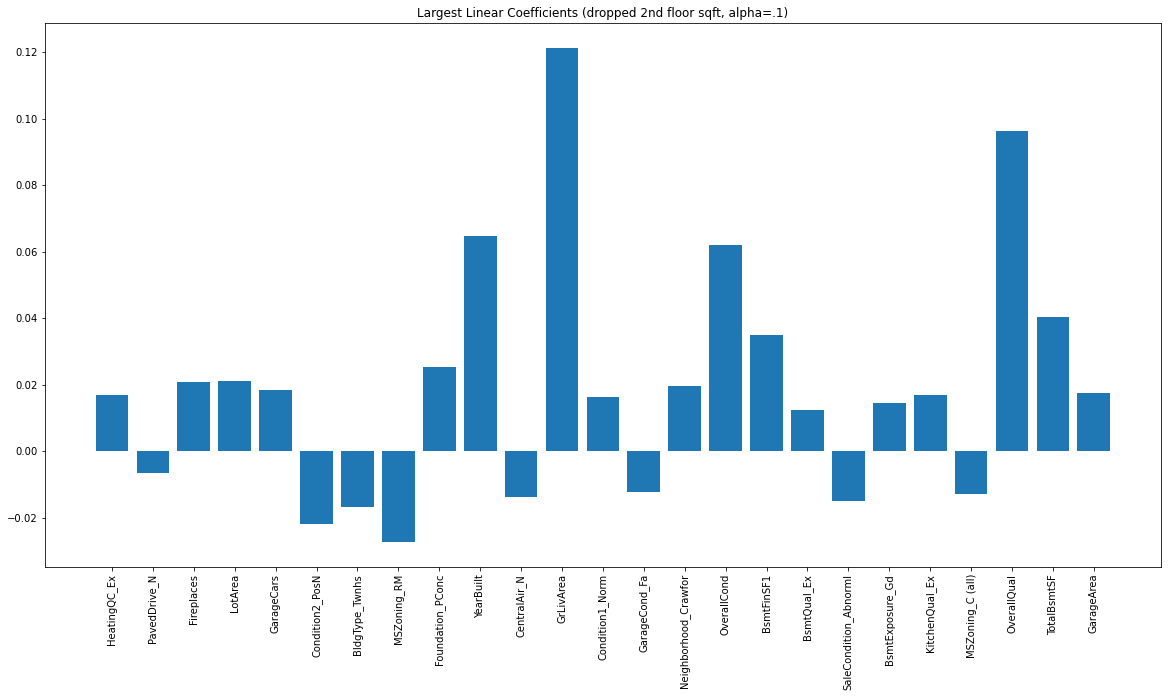

In [43]:
plt.rcParams["figure.figsize"] = (20, 10)
lin_coef=pipeline['linear'].coef_
names = X_train.columns
lin_zips=zip(names,lin_coef)
lin_coef_clean = [tup for tup in lin_zips if np.abs(tup[1])>.005]
names_clean_lin = [tup[0] for tup in lin_coef_clean]
coefs_clean_lin = [tup[1] for tup in lin_coef_clean]

plt.bar(names_clean_lin, coefs_clean_lin)
plt.title('Largest Linear Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [45]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train,X_train)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     896.2
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:56:49   Log-Likelihood:                 1618.0
No. Observations:                2046   AIC:                            -3184.
Df Residuals:                    2020   BIC:                            -3038.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.21

In [46]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train,X_train)
results = model.fit(cov_type="hc0")
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     933.0
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:03:22   Log-Likelihood:                 1618.0
No. Observations:                2046   AIC:                            -3184.
Df Residuals:                    2020   BIC:                            -3038.
Df Model:                          25                                         
Covariance Type:                  hc0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.21

In [ ]:
X_df=pd.DataFrame(X,columns=deps)

In [85]:
X_df.shape

(2558, 144)

<AxesSubplot:>

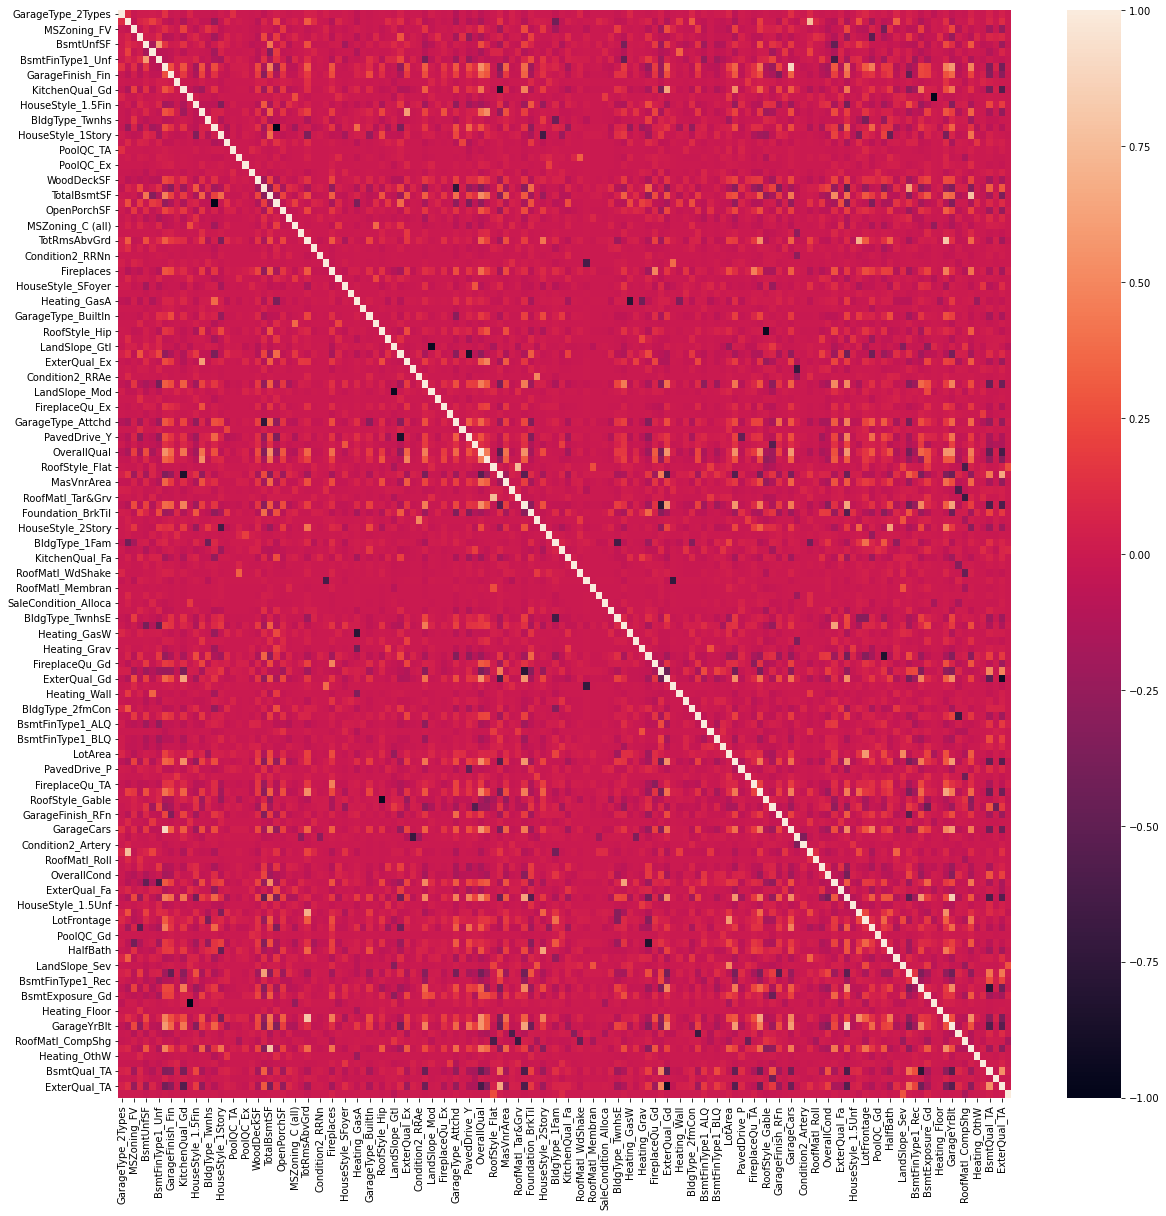

In [84]:
plt.rcParams["figure.figsize"] = (20, 20)
sns.heatmap(X_df.corr())

https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

In [89]:
from sklearn.linear_model import Lasso
from  sklearn.feature_selection import RFE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=70,step=10,verbose=1)
rfe.fit(X_train,y_train)
cols_selected_lasso=list(alldata[deps].columns[rfe.support_])

Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
Fitting estimator with 114 features.
Fitting estimator with 104 features.
Fitting estimator with 94 features.
Fitting estimator with 84 features.
Fitting estimator with 74 features.


/tmp/ipykernel_44914/4208612348.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cols_selected_lasso=list(alldata[deps].columns[rfe.support_])


In [117]:
cols_selected_lasso_=cols_selected_lasso.remove('GarageYrBlt')
cols_selected_lasso_=cols_selected_lasso_.remove('TotalRmsAbvGrnd')

y=alldata['LogPrice'].values
X=alldata[cols_selected_lasso].values
names = alldata[deps].columns

ValueError: list.remove(x): x not in list

In [102]:
steps = [('scaling',StandardScaler()),
('lasso',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.852529231385973
r2 score on test: 0.8804821935120489


In [103]:
X_df=pd.DataFrame(X,columns=cols_selected_lasso)

<AxesSubplot:>

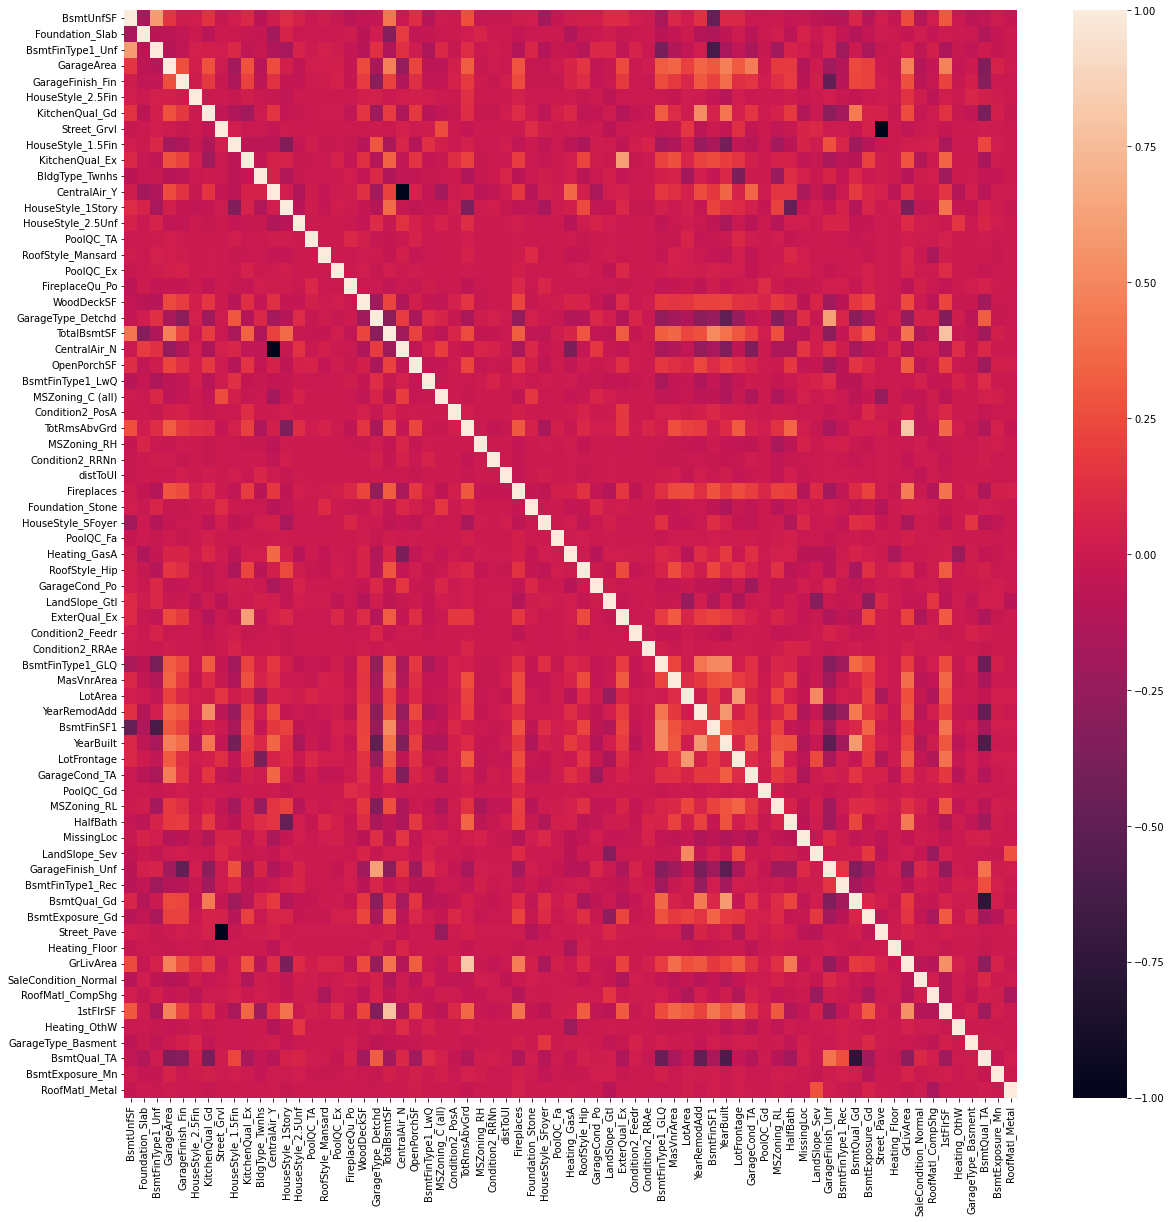

In [116]:
plt.rcParams["figure.figsize"] = (20, 20)
mask = X_df.corr()>.2
#X_df[mask].head()
sns.heatmap(X_df.corr())

In [97]:
import statsmodels.api as sm
x = sm.add_constant(X)
y=y
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y,x)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     255.2
Date:                Thu, 06 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:02:26   Log-Likelihood:                 1472.6
No. Observations:                2558   AIC:                            -2807.
Df Residuals:                    2489   BIC:                            -2404.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8870      0.248      7.596      0.0

### Attempt 2: Redo lasso on scaled + Add RFs?

In [11]:
from sklearn.feature_extraction import DictVectorizer

In [25]:
# #X_train, X_test, y_train, y_test = train_test_split_custom()  
# steps = [
#     ('dummify',DictVectorizer(sparse=False)),
#     ('scaling',StandardScaler()),
# ('lasso',LinearRegression())]
# pipeline = Pipeline(steps)

# X_train, X_test, y_train, y_test = train_test_split_custom(vectorize=True)  
# pipeline.fit(X_train,y_train)
# preds = pipeline.predict(X_test)
# print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
# #print(f'Lasso best params: {pipeline.best_params_}')


In [29]:
nums = [col for col in alldata.columns if alldata.dtypes[col] != 'object']
cats = [col for col in alldata.columns if alldata.dtypes[col] == 'object']
alldata=pd.get_dummies(alldata).reset_index(drop=True)

In [31]:
alldata.head()

,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lats,longs,MissingLoc,distToUI,LogPrice,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fi

In [32]:
#X_train, X_test, y_train, y_test = train_test_split_custom()  
steps = [
    ('scaling',StandardScaler()),
('lasso',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata)  
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.9686933219812575
r2 score on test: -3.0838001953347326e+23


In [35]:
from sklearn.linear_model import Lasso

In [39]:
list(alldata.columns)

['GrLivArea',
 'SalePrice',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'lats',
 'longs',
 'MissingLoc',
 'distToUI',
 'LogPrice',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_I (all)',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSewr',
 'LotConfig_Corner',
 'LotConfig

In [40]:
alldata = alldata.drop(['2ndFlrSF'],axis=1)
steps = [('scaling',StandardScaler()),
('lasso',Lasso(alpha=.01))]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test =  train_test_split_custom(data=alldata)  
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.968724919691836
r2 score on test: 0.9627809879507399


/home/dpv/mambaforge/envs/fastClean/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+11, tolerance: 1.130e+09
  model = cd_fast.enet_coordinate_descent(


In [15]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE on Test: {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 on Test: {r2}')

    return model

## Naive Linear Regression

### Without log price

In [16]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE on Test: 3281.184543552226
R^2 on Test: -69212967.47472031


LinearRegression()

### With log price

In [17]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE on Test: 3281.184543552226
R^2 on Test: -69212967.47472031


LinearRegression()

- A 'plain' linear regression is a poor match for the problem, performing considerably worse than predicting the average (ignoring the information in the dependent variables).

In [ ]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)

pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


In [45]:
cols_=((set(alldata.columns)|set(['LogPrice']))-set(['2ndFlrSF']))-set(['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(cols_),y_var='LogPrice')  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
rfe.fit(X_train,y_train)
cols_selected_lasso=list(X_train.columns[rfe.support_])

#cols_selected_lasso

KeyError: "['LogPrice'] not in index"

## Peforming Linear Regression with a subset of the features

#### Size-related columns

In [177]:
size_related = alldata.filter(regex='SF$|Area$')


In [178]:
size_related.head()

,GrLivArea,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea
0,856,7890,0.0,618.0,856.0,856,0,0,399.0,0,0,0
1,1049,4235,149.0,104.0,1049.0,1049,0,0,266.0,0,105,0
2,1001,6060,0.0,100.0,837.0,1001,0,0,216.0,154,0,0
3,1039,8146,0.0,405.0,405.0,717,322,0,281.0,0,0,0
4,1665,8400,0.0,167.0,810.0,810,855,0,528.0,0,45,0


In [179]:
size_cols=set(size_related.columns)

#### Neighborhood columns

In [180]:
ngh_related = alldata.filter(regex='^Neighborhood')


In [181]:
ngh_related.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [182]:
ngh_cols=set(ngh_related.columns)

#### Condition columns

In [183]:
cond_related = alldata.filter(regex='^Condition|^ExterCond|^BsmtCond')


In [184]:
cond_related.head()

,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [185]:
cond_cols=set(cond_related.columns)

In [186]:
qual_related = alldata.filter(regex='^KitchenQual')  #|^BasementQual')


In [187]:
qual_related.head()

,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [188]:
qual_cols=set(qual_related.columns)

In [189]:
street_related = alldata.filter(regex='^Street')

In [190]:
street_related.head()

,Street_Grvl,Street_Pave
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [191]:
street_cols=set(street_related.columns)

#### Garage-related columns

In [192]:
garage_related = alldata.filter(regex='^Garage') #extra cols will be dropped when we make the set

In [193]:
garage_related.head()

,GarageYrBlt,GarageCars,GarageArea,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA
0,1939.0,2.0,399.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
1,1984.0,1.0,266.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1930.0,1.0,216.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
3,1940.0,1.0,281.0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
4,2001.0,2.0,528.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [194]:
garage_cols=set(garage_related.columns)

In [195]:
air_related = alldata.filter(regex='^Central') #extra cols will be dropped when we make the set

In [196]:
air_related.head()

,CentralAir_N,CentralAir_Y
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [197]:
air_cols=set(air_related.columns)

In [198]:
fireplace_related = alldata.filter(regex='^Fireplace') #extra cols will be dropped when we make the set

In [199]:
fireplace_related.head()

,Fireplaces,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA
0,1,0,0,1,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [200]:
fireplace_cols=set(fireplace_related.columns)

In [201]:
salecondition_related = alldata.filter(regex='^SaleCondition') #extra cols will be dropped when we make the set

In [202]:
salecondition_related.head()

,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [203]:
salecondition_cols=set(salecondition_related.columns)

In [204]:
ssnporch_related = alldata.filter(regex='^3SsnPorch') #extra cols will be dropped when we make the set

In [205]:
ssnporch_related.head()

,3SsnPorch
0,0
1,0
2,86
3,0
4,0


In [206]:
ssnporch_cols=set(ssnporch_related.columns)

In [207]:
extrqual_related = alldata.filter(regex='^ExterQual') #extra cols will be dropped when we make the set

In [208]:
extrqual_related.head()

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [209]:
extrqual_cols=set(extrqual_related.columns)

In [210]:
zoning_related = alldata.filter(regex='^MSZoning') #extra cols will be dropped when we make the set

In [211]:
zoning_related.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [212]:
zoning_cols=set(zoning_related.columns)

In [213]:
bldg_related = alldata.filter(regex='^BuildingType') #extra cols will be dropped when we make the set

In [214]:
bldg_related.head()

""
0
1
2
3
4


In [215]:
bldg_cols=set(bldg_related.columns)

In [216]:
feature_imp_cols=set(['OverallQual','OverallCond','lats','longs','YearBuilt','YearRemodAdd','GarageCars','Fireplaces','LotArea','LotFrontage'])#,'BsmtFullBath'])

In [217]:
alldata.head()

,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageF

In [218]:
alldata.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'SaleType_Oth', 'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'LogPrice'],
      dtype='object', length=299)

In [219]:
price_col=set(['LogPrice','SalePrice']) #will be dropped in train-valid split

In [220]:
final_cols=size_cols|price_col|feature_imp_cols#|ngh_cols|cond_cols|extrqual_cols|qual_cols|street_cols|garage_cols|air_cols|bldg_cols|set(['distToUI'])#|basement_kitchen_cols#|zoning_cols#|ssnporch_cols#|fireplace_cols|salecondition_cols

In [221]:
#final_cols=size_cols|ngh_cols|price_col

In [222]:
final_cols

{'1stFlrSF',
 '2ndFlrSF',
 'BsmtUnfSF',
 'Fireplaces',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'LogPrice',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'SalePrice',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'lats',
 'longs'}

## Performing ElasticNet regression on the whole data set

- Get higher R^2 if remove expensive houses. This should be acceptable since prime real estate is generally of less interest as student housing

In [223]:
import numpy as np
from scipy import stats
alldata_=alldata[(np.abs(stats.zscore(alldata[['LogPrice']])) < 3).all(axis=1)]

In [224]:
X_train, X_test, y_train, y_test = split_into_train_test(alldata_[list(final_cols)])  

In [225]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')


cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [226]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')

#def run_elastic()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model2 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model2.fit(X_train, y_train)


ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [227]:
preds = model2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print(f'RMSE on Test: {rmse}')
r2 = r2_score(y_test, preds)
print(f'R^2 on Test: {r2}')

RMSE on Test: 0.1146347716956193
R^2 on Test: 0.9021381157389402


In [228]:
residuals = y_test - preds

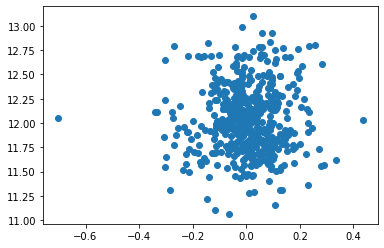

In [229]:
plt.scatter(residuals,preds)

In [230]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [231]:
def plot_resids():
    model=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()    

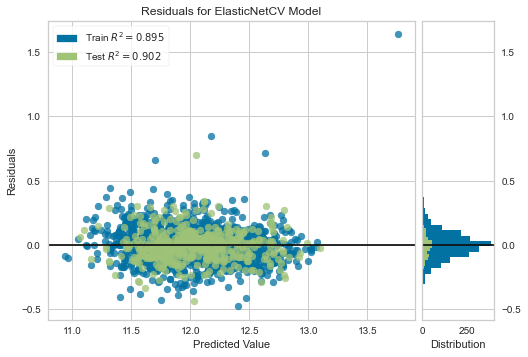

<AxesSubplot:title={'center':'Residuals for ElasticNetCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [232]:
model3=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
visualizer = ResidualsPlot(model3)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()    

In [233]:
def plot_qq(model):
    model=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
    visualizer = ResidualsPlot(model,hist=False,qqplot=True)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()    

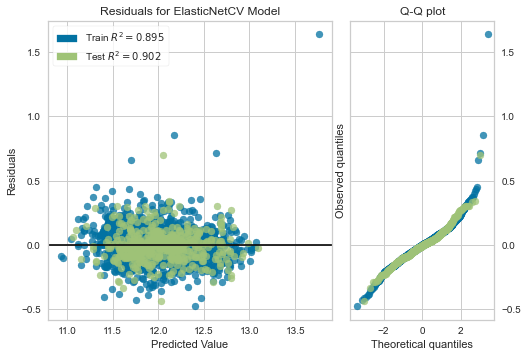

<AxesSubplot:title={'center':'Residuals for ElasticNetCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [234]:
model3=ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
visualizer = ResidualsPlot(model3,hist=False,qqplot=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()    

- There is some evidence for non-normality of residuals according to Q-Q plot

In [235]:
elastic_coefs=list(zip(model2.coef_,X_train.columns))

len(elastic_coefs)

#elastic_coefs_=
elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

len(elastic_coefs_)

sorted(elastic_coefs_,key=lambda x:x[1], reverse=True)

[('OverallQual', 0.07895681194529877),
 ('Fireplaces', 0.047595771967263986),
 ('OverallCond', 0.04062457473855262),
 ('GarageCars', 0.023007223026947028),
 ('YearBuilt', 0.0027845602216564347),
 ('YearRemodAdd', 0.0012513159614605568),
 ('LotFrontage', 0.0006979605044661325),
 ('GrLivArea', 0.00023558391552946456),
 ('TotalBsmtSF', 0.00017559897081075035),
 ('GarageArea', 0.00012170064179707393),
 ('WoodDeckSF', 3.855514200613504e-05),
 ('1stFlrSF', 1.6259420502837728e-05),
 ('OpenPorchSF', 1.0675800733343396e-05),
 ('LotArea', 1.7501290724187547e-06),
 ('BsmtUnfSF', -7.050904742618732e-05)]

In [236]:
elastic_var_names=[x[0] for x in elastic_coefs_]

In [237]:
#Helpful code: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
def print_vifs():
    from statsmodels.stats.outliers_influence import variance_inflation_factor


    vif_data = pd.DataFrame()
    vif_data["feature"] = elastic_var_names

    vif_data["VIF"] = [variance_inflation_factor(alldata[elastic_var_names].values, i)
                              for i in range(len(alldata[elastic_var_names].columns))]

    print(vif_data)
#print_vifs()

In [238]:
#Helpful code: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
def print_vifs():
    from statsmodels.stats.outliers_influence import variance_inflation_factor


    vif_data = pd.DataFrame()
    vif_data["feature"] = elastic_var_names

    vif_data["VIF"] = [variance_inflation_factor(alldata[elastic_var_names].values, i)
                              for i in range(len(alldata[elastic_var_names].columns))]

    print(vif_data)
#print_vifs()

In [239]:
import pickle
pickle.dump(model2, open('./models/model_elastic', 'wb'))


In [240]:
def split_drop_train_test(alldata,drop=[]):
    y=alldata['LogPrice']
    X=alldata.drop(['SalePrice','LogPrice']+drop,axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = split_into_train_test(alldata)  

In [241]:
X_train, X_test, y_train, y_test = split_drop_train_test(alldata,drop=['2ndFlrSF','Exterior2nd_PreCast'])#,'CentralAir_Y'])#,'Exterior1st_PreCast'])  

In [242]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model3 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model3.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [243]:
def eval_results(model):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE on Test: {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 on Test: {r2}')

In [244]:
preds = model3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print(f'RMSE on Test: {rmse}')
r2 = r2_score(y_test, preds)
print(f'R^2 on Test: {r2}')

RMSE on Test: 0.11048380158473162
R^2 on Test: 0.921526435416841


In [245]:
elastic_coefs=list(zip(model3.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

#elastic_var_names

print_vifs()

                   feature           VIF
0                GrLivArea     11.279309
1              LotFrontage      2.549613
2                  LotArea      1.893861
3              OverallQual      4.147908
4              OverallCond      2.092933
5                YearBuilt     10.351621
6             YearRemodAdd      2.882926
7               MasVnrArea      1.721854
8               BsmtFinSF1      2.946745
9               BsmtFinSF2      1.696547
10             TotalBsmtSF      4.390550
11                1stFlrSF      7.625768
12            LowQualFinSF      1.163776
13            BsmtFullBath      2.100941
14                FullBath      3.094989
15                HalfBath      2.455644
16            TotRmsAbvGrd      3.957561
17              Fireplaces      2.069466
18             GarageYrBlt      5.648194
19              GarageCars      6.597967
20              GarageArea      6.390433
21              WoodDeckSF      1.331757
22             OpenPorchSF      1.301484
23           Enc

In [246]:
#Get much higher R^2 if remove all houses with outliers
import numpy as np
from scipy import stats
alldata_=alldata[(np.abs(stats.zscore(alldata[['LogPrice']])) < 2.5).all(axis=1)]

In [247]:
def split_drop_train_test(alldata,drop=[]):
    y=alldata['LogPrice']
    X=alldata.drop(['SalePrice','LogPrice']+drop,axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)

In [248]:
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=['2ndFlrSF'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

In [249]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model4 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model4.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [250]:
eval_results(model4)

RMSE on Test: 0.0910443422512221
R^2 on Test: 0.9320113391924636


In [251]:
elastic_coefs=list(zip(model4.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

#elastic_var_names

print_vifs()

                   feature         VIF
0                GrLivArea   11.845333
1              LotFrontage    2.527582
2                  LotArea    1.960270
3              OverallQual    4.375839
4              OverallCond    2.108784
5                YearBuilt   11.437330
6             YearRemodAdd    2.946144
7               MasVnrArea    1.743993
8               BsmtFinSF1    3.219127
9               BsmtFinSF2    1.652132
10             TotalBsmtSF    5.666252
11                1stFlrSF    7.935209
12            LowQualFinSF    1.158687
13            BsmtFullBath    2.136390
14                FullBath    3.209200
15                HalfBath    2.514239
16            KitchenAbvGr    3.476514
17            TotRmsAbvGrd    4.088595
18              Fireplaces    2.102496
19             GarageYrBlt    5.557277
20              GarageCars    6.708989
21              GarageArea    6.525171
22              WoodDeckSF    1.341193
23             OpenPorchSF    1.310743
24           EnclosedPorc

- Get even more serious multicollinearity problem!

In [252]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')

In [253]:
def report_results(data=alldata_,drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub']):
    X_train, X_test, y_train, y_test = split_drop_train_test(alldata=alldata_,drop=drop)#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    # define model
    ratios = np.arange(0, 1, 0.01)
    alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
    model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
    # fit model
    model=model.fit(X_train, y_train)
    eval_results(model)
    #get coef names
    elastic_coefs=list(zip(model.coef_,X_train.columns))

    elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

    elastic_var_names=[x[0] for x in elastic_coefs_]

    print_vifs()
    
    print(sorted(elastic_coefs,key=lambda x:x[1], reverse=True))#change back to _
    
    return model

In [254]:
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub'])#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model5 = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model5.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1, normalize=True)

In [255]:
eval_results(model5)

RMSE on Test: 0.09100370216611023
R^2 on Test: 0.9320720227716836


In [256]:
elastic_coefs=list(zip(model5.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

#elastic_var_names

print_vifs()

                   feature         VIF
0                GrLivArea   11.788464
1              LotFrontage    2.527089
2                  LotArea    1.957745
3              OverallQual    4.360590
4              OverallCond    2.065847
5                YearBuilt   11.422058
6             YearRemodAdd    2.934797
7               MasVnrArea    1.742189
8               BsmtFinSF1    3.213264
9               BsmtFinSF2    1.649023
10             TotalBsmtSF    5.647334
11                1stFlrSF    7.910674
12            LowQualFinSF    1.158369
13            BsmtFullBath    2.136349
14                FullBath    3.191440
15                HalfBath    2.504214
16            KitchenAbvGr    3.472793
17            TotRmsAbvGrd    4.083172
18              Fireplaces    2.096811
19             GarageYrBlt    5.536315
20              GarageCars    6.651148
21              GarageArea    6.412379
22              WoodDeckSF    1.338307
23             OpenPorchSF    1.309491
24           EnclosedPorc

In [257]:
elastic_coefs5=list(zip(model5.coef_,X_train.columns))

len(elastic_coefs5)

elastic_coefs5_=[(coef[1],coef[0]) for coef in elastic_coefs5 if abs(coef[0])>0]

len(elastic_coefs5_)

sorted(elastic_coefs5,key=lambda x:x[1], reverse=True)#change back to _

[(0.0, 'longs'),
 (-0.0, 'lats'),
 (-1.3338746713348387e-06, 'distToUI'),
 (-0.0, 'YrSold'),
 (0.0007312953561685371, 'YearRemodAdd'),
 (0.001206258677547179, 'YearBuilt'),
 (3.85712057387708e-05, 'WoodDeckSF'),
 (7.349945079006288e-05, 'TotalBsmtSF'),
 (0.008071754265450256, 'TotRmsAbvGrd'),
 (0.02020302261230589, 'Street_Pave'),
 (-0.020215601123225256, 'Street_Grvl'),
 (0.00011968605169829893, 'ScreenPorch'),
 (-0.0, 'SaleType_WD '),
 (-0.0, 'SaleType_VWD'),
 (-0.04455719619975689, 'SaleType_Oth'),
 (0.0, 'SaleType_New'),
 (0.0, 'SaleType_ConLw'),
 (-0.0, 'SaleType_ConLI'),
 (-0.0, 'SaleType_ConLD'),
 (0.09251415694221453, 'SaleType_Con'),
 (0.00020554298875154813, 'SaleType_CWD'),
 (-0.007488106896731469, 'SaleType_COD'),
 (0.018843901675088075, 'SaleCondition_Partial'),
 (0.0, 'SaleCondition_Normal'),
 (-0.10157733217481635, 'SaleCondition_Family'),
 (0.031448861918629195, 'SaleCondition_Alloca'),
 (0.0, 'SaleCondition_AdjLand'),
 (-0.042501331339575656, 'SaleCondition_Abnorml'),


In [258]:
drop=['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub','Street_Grvl','ExterQual_Ex']
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=drop)#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model.fit(X_train, y_train)

eval_results(model)

elastic_coefs=list(zip(model.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]


print_vifs()



sorted(elastic_coefs,key=lambda x:x[1], reverse=True)#change back to _

RMSE on Test: 0.09112012804672856
R^2 on Test: 0.9318981038363152
                   feature           VIF
0                GrLivArea  1.199722e+02
1              LotFrontage  2.634589e+01
2                  LotArea  4.959767e+00
3              OverallQual  9.068353e+01
4              OverallCond  5.401510e+01
5                YearBuilt  3.564845e+04
6             YearRemodAdd  2.185215e+04
7               MasVnrArea  2.293033e+00
8               BsmtFinSF1  6.659295e+00
9               BsmtFinSF2  1.801720e+00
10             TotalBsmtSF  4.068905e+01
11                1stFlrSF  8.120664e+01
12            LowQualFinSF  1.168741e+00
13            BsmtFullBath  3.650066e+00
14                FullBath  2.824547e+01
15                HalfBath  3.873884e+00
16            KitchenAbvGr  9.351085e+01
17            TotRmsAbvGrd  7.483598e+01
18              Fireplaces  3.917934e+00
19             GarageYrBlt  2.978670e+04
20              GarageCars  4.366076e+01
21              GarageArea  3.87

[(0.0, 'longs'),
 (-0.0, 'lats'),
 (-1.4029252501373344e-06, 'distToUI'),
 (-0.0, 'YrSold'),
 (0.0007325187177621178, 'YearRemodAdd'),
 (0.0012073898333226985, 'YearBuilt'),
 (3.875105718892587e-05, 'WoodDeckSF'),
 (7.354376325708964e-05, 'TotalBsmtSF'),
 (0.008096114724271146, 'TotRmsAbvGrd'),
 (0.0385790119768416, 'Street_Pave'),
 (0.00011979093102936217, 'ScreenPorch'),
 (-0.0, 'SaleType_WD '),
 (-0.0, 'SaleType_VWD'),
 (-0.04420590234126796, 'SaleType_Oth'),
 (0.0, 'SaleType_New'),
 (0.0, 'SaleType_ConLw'),
 (-0.0, 'SaleType_ConLI'),
 (-0.0, 'SaleType_ConLD'),
 (0.0921917069014737, 'SaleType_Con'),
 (0.0, 'SaleType_CWD'),
 (-0.007358746002472986, 'SaleType_COD'),
 (0.019378085623154764, 'SaleCondition_Partial'),
 (0.0, 'SaleCondition_Normal'),
 (-0.10177818024026677, 'SaleCondition_Family'),
 (0.031044431060081926, 'SaleCondition_Alloca'),
 (0.0, 'SaleCondition_AdjLand'),
 (-0.04273511026864324, 'SaleCondition_Abnorml'),
 (0.0, 'RoofStyle_Shed'),
 (-0.014947265014260821, 'RoofStyle

In [283]:
# drop=(['2ndFlrSF','CentralAir_N','Utilities_NoSewr','Utilities_AllPub',
#       'Street_Grvl','ExterQual_Ex','Exterior1st_PreCast','GarageYrBlt',
#       'KitchenQual_Gd'])
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

alldata_=alldata[(np.abs(stats.zscore(alldata[['LogPrice']])) < 3).all(axis=1)]

drop_=(['2ndFlrSF','CentralAir_N'])
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=drop_)#,'GarageYrBlt'])#,'GarageYrBlt'])#,'GarageCars'])#,'MSZoning_RL'])#,'Utilities_NoSewr'])#,'2ndFlrSF','Exterior2nd_PreCast''CentralAir_Y'])#,'Exterior1st_PreCast'])  
print("Dropped vars: ")
print(drop_)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, normalize=True)
# fit model
model.fit(X_train, y_train)

eval_results(model)

elastic_coefs=list(zip(model.coef_,X_train.columns))

elastic_coefs_=[(coef[1],coef[0]) for coef in elastic_coefs if abs(coef[0])>0]

elastic_var_names=[x[0] for x in elastic_coefs_]

print("+++++++++++++++++VIFs++++++++++++++++++")
print_vifs()


print("+++++++++++++++++COEFs++++++++++++++++++")

sorted(elastic_coefs_,key=lambda x:x[1], reverse=True)#change back to _

Dropped vars: 
['2ndFlrSF', 'CentralAir_N']
RMSE on Test: 0.0970006127196732
R^2 on Test: 0.9299303758598287
+++++++++++++++++VIFs++++++++++++++++++
                   feature           VIF
0                GrLivArea      8.618162
1              LotFrontage      2.450688
2                  LotArea      1.893542
3              OverallQual      4.119725
4              OverallCond      1.998155
5                YearBuilt      9.757746
6             YearRemodAdd      2.861509
7               MasVnrArea      1.645644
8               BsmtFinSF1      2.947581
9               BsmtFinSF2      1.609421
10             TotalBsmtSF      5.677502
11                1stFlrSF      5.803352
12            BsmtFullBath      2.093586
13                FullBath      3.050164
14                HalfBath      2.401897
15            KitchenAbvGr      2.369897
16            TotRmsAbvGrd      3.987657
17              Fireplaces      2.032524
18             GarageYrBlt      5.411342
19              GarageCars     

[('Neighborhood_Crawfor', 0.09861470818644553),
 ('Neighborhood_StoneBr', 0.08593974983023403),
 ('RoofMatl_WdShngl', 0.07681084203289827),
 ('Exterior1st_BrkFace', 0.05911214416045777),
 ('Neighborhood_Somerst', 0.05843670505496856),
 ('OverallQual', 0.052403494661937944),
 ('BsmtExposure_Gd', 0.050906137792147615),
 ('Neighborhood_NridgHt', 0.042584608582549935),
 ('CentralAir_Y', 0.040951763984311676),
 ('Neighborhood_NoRidge', 0.03891146368792283),
 ('BsmtQual_Ex', 0.037999016157571334),
 ('Utilities_AllPub', 0.0354805548265226),
 ('KitchenQual_Ex', 0.03405222429561726),
 ('OverallCond', 0.03388980440121362),
 ('Fireplaces', 0.033399338116582356),
 ('Functional_Typ', 0.0332569411430907),
 ('SaleType_Con', 0.02901619089574798),
 ('Neighborhood_ClearCr', 0.028948308699175522),
 ('Exterior1st_BrkComm', 0.025926950217822046),
 ('BldgType_1Fam', 0.02526053835671068),
 ('Condition1_Norm', 0.025214523704275047),
 ('GarageCars', 0.024541753793218202),
 ('HeatingQC_Ex', 0.021001948155690085

In [284]:
#import pickle
#pickle.dump(model, open('./models/model_elastic_3std', 'wb'))

In [285]:
#pickle.load('./models/model_elastic_3std')
model =pickle.load(open('./models/model_elastic_3std', 'rb'))

In [286]:
y_hats = model.predict(X_test)

y_test['preds'] = y_hats
df_out = pd.merge(alldata_,y_test[['preds']],how = 'left',left_index = True, right_index = True)
df_out.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'SaleType_VWD', 'SaleType_WD ', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'LogPrice_x',
       'LogPrice_y'],
      dtype='object', length=300)

## Writing a dataframe for the first app version

- I eventually decided to use an ensemble of tree models due to nonnormality and multicollinearity concerns.

In [287]:
drop_=(['2ndFlrSF','CentralAir_N'])
X_train, X_test, y_train, y_test = split_drop_train_test(alldata_,drop=drop_)


In [288]:
X_all=X_test

In [289]:
X_all['preds']=np.exp(model.predict(X_test))

In [290]:
X_all.to_csv("./data/test_and_pred.csv",index=False)

In [291]:
np.shape(X_all)

(508, 296)

In [292]:
X_all.head()

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,Garag

In [293]:
full=pd.read_csv('./data/Ames_HousePriceLocsFULL.csv')#, index_col=0) #already cleaned (see work in appendix files)


In [294]:
new_df = pd.merge(X_all, full,  how='left', left_on=['lats','longs'], right_on = ['lats','longs'])

In [295]:
new_df.head()

,GrLivArea_x,MSSubClass_x,LotFrontage_x,LotArea_x,OverallQual_x,OverallCond_x,YearBuilt_x,YearRemodAdd_x,MasVnrArea_x,BsmtFinSF1_x,BsmtFinSF2_x,BsmtUnfSF_x,TotalBsmtSF_x,1stFlrSF_x,LowQualFinSF_x,BsmtFullBath_x,BsmtHalfBath_x,FullBath_x,HalfBath_x,BedroomAbvGr_x,KitchenAbvGr_x,TotRmsAbvGrd_x,Fireplaces_x,GarageYrBlt_x,GarageCars_x,GarageArea_x,WoodDeckSF_x,OpenPorchSF_x,EnclosedPorch_x,3SsnPorch_x,ScreenPorch_x,PoolArea_x,MiscVal_x,MoSold_x,YrSold_x,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,Gara

In [296]:
new_df.to_csv("./data/test_and_pred_full.csv",index=False)

In [297]:
new_df['CentralAir_Y'].head()

0    1
1    1
2    1
3    1
4    1
Name: CentralAir_Y, dtype: uint8

In [298]:
new_df[['GrLivArea_x','GrLivArea_y']].head()

,GrLivArea_x,GrLivArea_y
0,1728,1728.0
1,1492,1492.0
2,2726,NaN
3,1930,1930.0
4,1558,1558.0


In [299]:
new_df[['YearBuilt_x','YearBuilt_y']].head()

,YearBuilt_x,YearBuilt_y
0,2003,2003.0
1,2006,2006.0
2,1986,NaN
3,1927,1927.0
4,1950,1950.0


In [300]:
new_df.head()

,GrLivArea_x,MSSubClass_x,LotFrontage_x,LotArea_x,OverallQual_x,OverallCond_x,YearBuilt_x,YearRemodAdd_x,MasVnrArea_x,BsmtFinSF1_x,BsmtFinSF2_x,BsmtUnfSF_x,TotalBsmtSF_x,1stFlrSF_x,LowQualFinSF_x,BsmtFullBath_x,BsmtHalfBath_x,FullBath_x,HalfBath_x,BedroomAbvGr_x,KitchenAbvGr_x,TotRmsAbvGrd_x,Fireplaces_x,GarageYrBlt_x,GarageCars_x,GarageArea_x,WoodDeckSF_x,OpenPorchSF_x,EnclosedPorch_x,3SsnPorch_x,ScreenPorch_x,PoolArea_x,MiscVal_x,MoSold_x,YrSold_x,lats,longs,MissingLoc,distToUI,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,Gara

<AxesSubplot:>

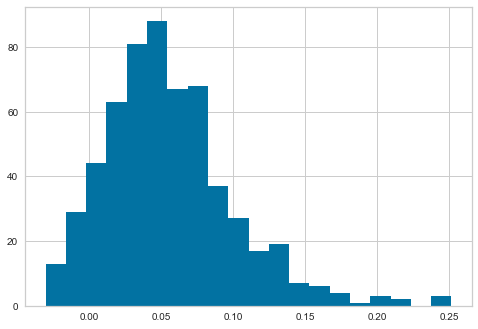

In [301]:
#Property taxes+maintenance costs+ insurance costs+ miscelaneous fees
costs_per_year=(.015+.02+.006+.01) 

def dist_premium_func(distance):
    if distance<.8:
        return 1.29
    elif distance < 1.3:
        return 1.05
    else:
        return 1

new_df['dist_premium'] = new_df.apply(lambda x: dist_premium_func(x.distToUI),axis=1)


def vac_rate_func(distance):
    if distance<.8:
        return .017
    elif distance < 1.3:
        return .025
    else:
        return .07

new_df['vac_rate'] = new_df.apply(lambda x: vac_rate_func(x.distToUI),axis=1)

#new_df['dist_premium']*(new_df.BedroomAbvGr_x)

new_df['noi']=new_df['dist_premium']*(500*12*new_df['BedroomAbvGr_x']*(1-new_df['vac_rate']))-new_df['preds']*costs_per_year

new_df['cap_rate']=new_df['noi']/new_df['preds']

new_df['cap_rate'].hist(bins=20)

In [302]:
new_df.to_csv("./data/test_and_pred_cap_rate.csv",index=False)

## Gettting the coefficient estimates and the p-values using statsmodels

In [303]:
X=alldata[list(final_cols)]
y=alldata['LogPrice']
X=alldata.drop(['SalePrice','LogPrice'],axis=1)

In [304]:
import statsmodels.api as sm
x = sm.add_constant(X)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y,x)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     139.2
Date:                Thu, 18 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:36:24   Log-Likelihood:                 2432.5
No. Observations:                2558   AIC:                            -4339.
Df Residuals:                    2295   BIC:                            -2801.
Df Model:                         262                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.53

In [305]:
import statsmodels.api as sm
x = sm.add_constant(X_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train,x)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     118.8
Date:                Thu, 18 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:36:24   Log-Likelihood:                 2097.2
No. Observations:                2032   AIC:                            -3682.
Df Residuals:                    1776   BIC:                            -2245.
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.28

# Sidenote on R^2 and encoding choice for tree models

As suspected, random forest performes worse when categorical variables are dummified rather than label-encoded.  This is the reason label encoding was used for tree models. 

In [307]:
# from sklearn.ensemble import RandomForestRegressor
# model_rf = RandomForestRegressor()
# run_model(model_rf,X_train,y_train,X_test,y_test)